# Notebook 04 - Feature Engineering

## Objectives

* Fetch data from Kaggle and save as raw data

## Inputs

* CSV file with cleaned data generated in notebook 02: outputs/datasets/cleaned/v1/credit_card_data_cleaned.csv

## Outputs

* Data split into train and test sets, saved in the outputs/datasets/cleaned/v1 folder
* List of variables and feature engineering steps


## Conclusions, Additional Comments

* [xxx]

## Feature Engineering Steps
* Split train and test sets before beginning to avoid data leakage
* Assess what feature engineering processes to apply to each variable


---

# Change working directory

* This notebook is stored in the `jupyter_notebooks` subfolder
* The current working directory therefore needs to be changed to the workspace, i.e., the working directory needs to be changed from the current folder to its parent folder

Firstly, the current directory is accessed with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\franc\\credit-card-default\\jupyter_notebooks'

Next, the working directory is set as the parent of the current `jupyter_notebooks` directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory
* This allows access to all the files and folders within the workspace, rather than solely those within the `jupyter_notebooks` directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Finally, confirm that the new current directory has been successfully set

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\franc\\credit-card-default'

---

# Load data

The data is loaded from the outputs/datasets/cleaned/v1 folder:

In [4]:
import pandas as pd
df = pd.read_csv('outputs/datasets/cleaned/v1/credit_card_data_cleaned.csv')
df.head()

,credit_limit,sex,education,marital_status,age,late_sep,late_aug,late_jul,late_jun,late_may,...,prev_payment_sep,prev_payment_aug,prev_payment_jul,prev_payment_jun,prev_payment_may,prev_payment_apr,default_next_month,any_default,total_default,greatest_default
0,20000.0,female,university,married,24,2,2,-1,-1,-2,...,0.0,689.0,0.0,0.0,0.0,0.0,1,1,4,2
1,120000.0,female,university,single,26,-1,2,0,0,0,...,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,1,4,2
2,90000.0,female,university,single,34,0,0,0,0,0,...,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,0,0,0
3,50000.0,female,university,married,37,0,0,0,0,0,...,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,0,0,0
4,50000.0,male,university,married,57,-1,0,-1,0,0,...,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,0,0,0


---

# Split train and test set

The train and test set must be split before feature engineering to avoid the potential for data leakage
* For example, consider a feature engineering step where data are scaled using the min and max values for the whole dataset
    - If this step were performed before feature engineering, this 'knowledge' of the range of the whole dataset would be indirectly included in the test set
    - Note that the data cleaning pipeline already applied to the data in notebook 02 does not contain any such steps, being limited to intrarow operations, dropping of a column that does not contain any predictive information and renaming of columns to conform to naming standards
    - More information and explanation on this topic is available at [Machine Learning Mastery](https://machinelearningmastery.com/data-preparation-without-data-leakage/)

The percentage of data to put into the train and test sets is a matter of some debate, with [Machine Learning Mastery](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/) noting that common split percentages include 80% : 20%, 67% : 33% or even 50% : 50%.

Some models using very large datasets can have much more extreme split percentages, with ratios as high as 99% : 1%.
  
The research article ["Optimal ratio for data splitting"](https://onlinelibrary.wiley.com/doi/full/10.1002/sam.11583) (Joseph, 2022) aims to mathematically formulate an optimal ratio based on the number of unique rows and predictor variables in the dataset
* Given that we do not know the number of predictor variables before beginning feature engineering, since some are likely to be removed when we apply `SmartCorrelatedSelection`, a method for estimating the number of predictor variables `p` is also provided, where `p` is the square root of the number of unique rows in the dataset, which in this case is 30,000, giving a value for `p` of 173.2
* The dataset can then be split in the ratio `√p : 1`: in this case, 13.2 : 1 or about 93% : 7%

Given the wide variety of split percentages suggested from various sources, a split of 80% : 20% is used here, since it is a generally accepted split and falls well within the ranges mentioned above.

In [5]:
from sklearn.model_selection import train_test_split

TrainSet, TestSet, _, __ = train_test_split(
    df,
    df['default_next_month'],
    test_size=0.2,
    random_state=42,
)
print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (24000, 27) 
TestSet shape: (6000, 27)


---

# Push train set and test set to repo

So that we have a record of the train and test set before any feature engineering processes are carried out, they are saved as `csv` files at this stage:

In [6]:
TrainSet.to_csv("outputs/datasets/cleaned/v1/train_set_cleaned.csv", index = False)
TestSet.to_csv("outputs/datasets/cleaned/v1/test_set_cleaned.csv", index = False)

---

# Feature Engineering Transformers

When deciding which feature engineering transformers to use, there are a number of considerations.
  
Categorical variables need to be encoded using categorical encoding.
* For variables where an ordinal relationship exists, `OrdinalEncoder` should be used. This is the case for `education` where there is a progression from high school through university to graduate school
* For variables where no ordinal relationship exists, it is important to avoid a situation where the model interprets an order or hierarchy where none exists. For this reason we cannot use `OrdinalEncoder` on `sex` and `marital_status` and instead use `OneHotEncoder`
* For both `education` and `marital_status` some values are `other` and some are `unknown`. Given these represent a small proportion of the total dataset, we can drop the unknown values using `DropMissingData`. The `other` value can be coded as 0 for `education` using `OrdinalEncoder` and included in the `OneHotEncoder` in `marital_status`

Numerical variables will undergo a series of numerical transformers in the hope that they can be brought close to a normal distribution.
* We see from the histograms of the numerical variables in notebook `03_data_analysis` that many of the variables are right skewed, so we might reasonably hope that a `LogTransformer` either in base e or base 10 will be of use
* We will also try `ReciprocalTransformer`, `PowerTransformer`, `BoxCoxTransformer` and `YeoJohnsonTransformer`
    - In particular, since several of the numerical variables include negative numbers, `LogTransformer` will not work and another transformer such as the `YeoJohnsonTransformer`, which can also be used with negative numbers, may be of more use
* If these do not provide useful transformations, the following can also be considered
    - `EqualFrequencyDiscretiser` could be used on several variables, since many of the variables have strong positive skew and their distribution would not be captured well by using equally spaced buckets
    - `ArbitraryDiscretiser` might also be useful if we have specific ranges that we want to consider for one or more variables

`SmartCorrelatedSelection` will also be used on all variables to identify and remove highly correlated features. This will help to avoid multicollinearity, which could risk overfitting and cause the model to be less good at generalising.
* It will also simplify the model and reduce computation time

---

# Categorical Encoding

As noted above, two types of categorical encoding will be used:
* `OneHotEncoder` for variables where no ordinal relationship exists: `sex` and `marital_status`
* `OrdinalEncoder` for `education` since there is a presumed ordinal relationship between levels of education
    - Note that we have added '0' to the `education_map` dictionary below, since in effect these (very few) examples are also unknown and can be coded as 0

In [7]:
variables_ohe = ['sex', 'marital_status']
variables_ord = ['education']
education_map = {
    '0': 0,
    'other': 0,
    'unknown': 0,
    'high school': 1,
    'university': 2,
    'graduate school': 3
}

For each set of variables, a separate dataframe is created containing the variables:

In [8]:
df_ohe = TrainSet[variables_ohe].copy()
df_ohe.head()

,sex,marital_status
21753,female,single
251,male,single
22941,female,married
618,male,single
17090,female,single


In [9]:
df_ord = TrainSet[variables_ord].copy()
df_ord.head()

,education
21753,university
251,university
22941,unknown
618,graduate school
17090,university


Engineered variables can then be created by applying the transformations and incorporated into the dataframe:

In [10]:
from feature_engine.encoding import OneHotEncoder
df = pd.read_csv('outputs/datasets/cleaned/v1/train_set_cleaned.csv')
encoder = OneHotEncoder(variables=variables_ohe, drop_last=True)
df_after_ohe = encoder.fit_transform(df)
df_after_ohe.head()


,credit_limit,education,age,late_sep,late_aug,late_jul,late_jun,late_may,late_apr,bill_sep,...,prev_payment_may,prev_payment_apr,default_next_month,any_default,total_default,greatest_default,sex_female,marital_status_single,marital_status_married,marital_status_other
0,80000.0,university,24,0,0,0,0,0,0,75125.0,...,1445.0,878.0,0,0,0,0,1,1,0,0
1,30000.0,university,28,0,0,0,0,0,0,29242.0,...,0.0,0.0,0,0,0,0,0,1,0,0
2,180000.0,unknown,44,0,0,-1,-1,-1,-1,20916.0,...,10340.0,182.0,0,0,0,0,1,0,1,0
3,60000.0,graduate school,25,0,0,0,0,0,0,58839.0,...,1900.0,2000.0,0,0,0,0,0,1,0,0
4,130000.0,university,25,0,0,0,0,0,0,111587.0,...,5000.0,10700.0,0,0,0,0,1,1,0,0


Since we want to specify the mapping of `education` to ensure the correct ordering of education levels (this is done above in `education_map`), and since we only need to encode this one variable in the manner used by `OrdinalEncoder`, it is actually simpler to code this without using the encoder, as follows:

In [11]:
df = df_after_ohe
df['education'] = df['education'].map(education_map)
df['education'] = df['education'].fillna(0)
df.head()

,credit_limit,education,age,late_sep,late_aug,late_jul,late_jun,late_may,late_apr,bill_sep,...,prev_payment_may,prev_payment_apr,default_next_month,any_default,total_default,greatest_default,sex_female,marital_status_single,marital_status_married,marital_status_other
0,80000.0,2,24,0,0,0,0,0,0,75125.0,...,1445.0,878.0,0,0,0,0,1,1,0,0
1,30000.0,2,28,0,0,0,0,0,0,29242.0,...,0.0,0.0,0,0,0,0,0,1,0,0
2,180000.0,0,44,0,0,-1,-1,-1,-1,20916.0,...,10340.0,182.0,0,0,0,0,1,0,1,0
3,60000.0,3,25,0,0,0,0,0,0,58839.0,...,1900.0,2000.0,0,0,0,0,0,1,0,0
4,130000.0,2,25,0,0,0,0,0,0,111587.0,...,5000.0,10700.0,0,0,0,0,1,1,0,0


---

# Numerical Variable Encoding

We want to try a series of transformations on the numerical variables, to see if we can transform some or all of them to be closer to a normal distribution.

First, we specify the variables to be considered.
* It is most straightforward to do this by creating a Python list rather than selecting all variables with a certain `Dtype`, since several category variables are stored in the database as `int` and we also want to consider, for example, `age` as a numerical variable, and this is also stored as `int`

In [12]:
numerical_vars = ['credit_limit', 'age', 'bill_sep', 'bill_aug', 'bill_jul', 'bill_jun', 'bill_may',
                'bill_apr', 'prev_payment_sep', 'prev_payment_aug', 'prev_payment_jul', 'prev_payment_jun',
                'prev_payment_may', 'prev_payment_apr']

The following cell is adapted from CI's Walkthrough Project 02 and used for transformation and visualisation:

In [13]:
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def feature_engineering_analysis(df, analysis_type=None):
    """
    Used for quick feature engineering on numerical variables to decide
    which transformation is best to transform the distribution shape
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop through each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # Create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass the analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"The analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a number of missing values in your dataset. Please handle that before performing feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers: 
        DiagnosticPlots_Numerical(df_feat_eng, col)     
        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


In [14]:
df_engineering = TrainSet[numerical_vars].copy()
df_engineering.head(3)

,credit_limit,age,bill_sep,bill_aug,bill_jul,bill_jun,bill_may,bill_apr,prev_payment_sep,prev_payment_aug,prev_payment_jul,prev_payment_jun,prev_payment_may,prev_payment_apr
21753,80000.0,24,75125.0,77353.0,78321.0,73731.0,39643.0,39457.0,3503.0,5001.0,2092.0,1218.0,1445.0,878.0
251,30000.0,28,29242.0,29507.0,29155.0,25255.0,22001.0,0.0,5006.0,1244.0,851.0,955.0,0.0,0.0
22941,180000.0,44,20916.0,0.0,850.0,0.0,6881.0,10340.0,0.0,850.0,0.0,6881.0,10340.0,182.0


* Variable Analyzed: credit_limit
* Applied transformation: ['credit_limit_log_e', 'credit_limit_log_10', 'credit_limit_reciprocal', 'credit_limit_power', 'credit_limit_box_cox', 'credit_limit_yeo_johnson'] 



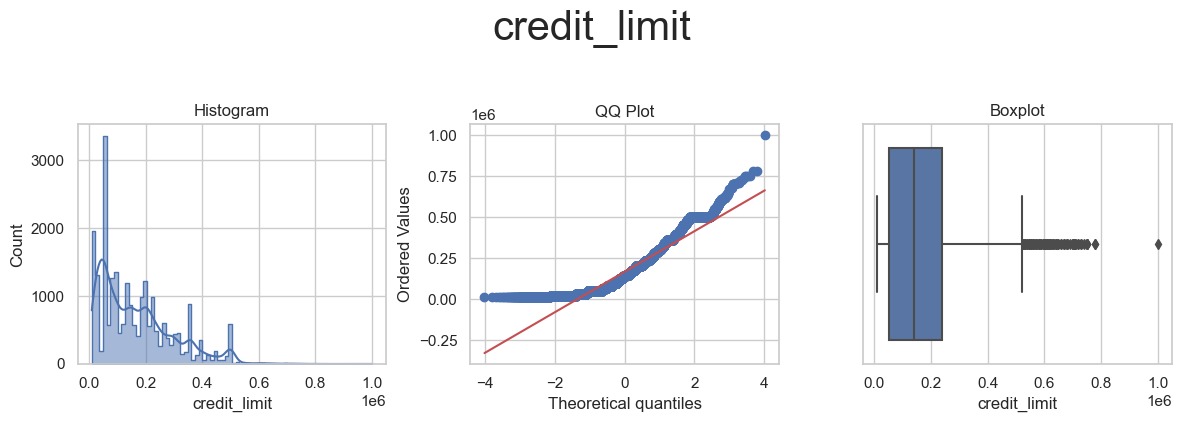

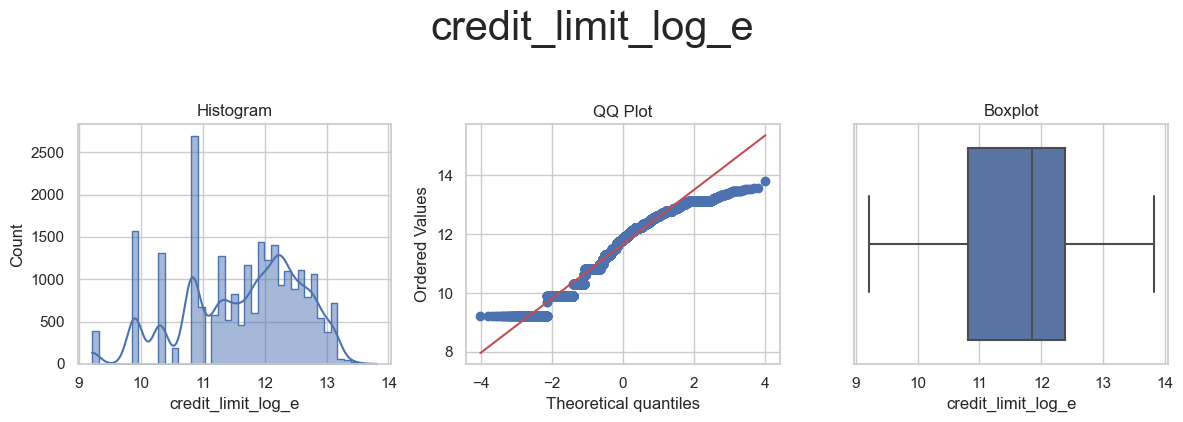

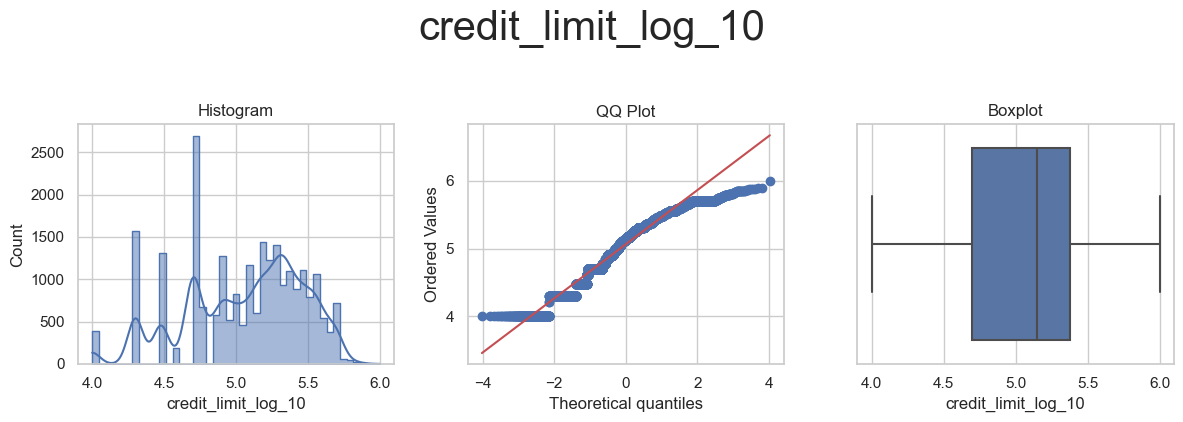

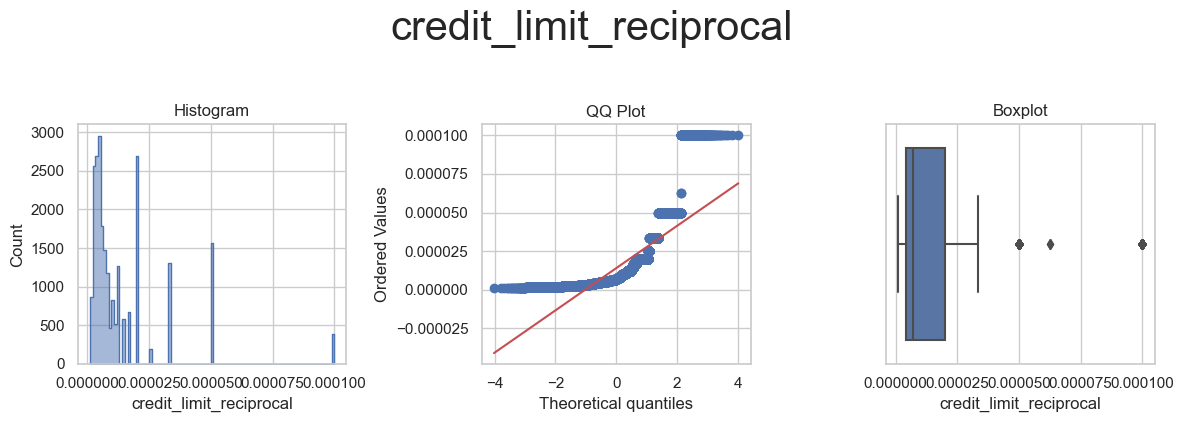

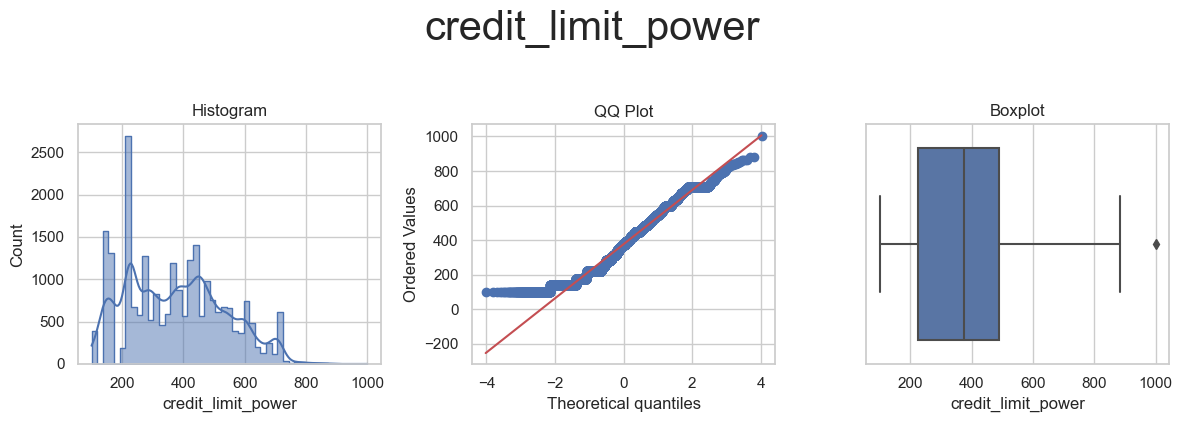

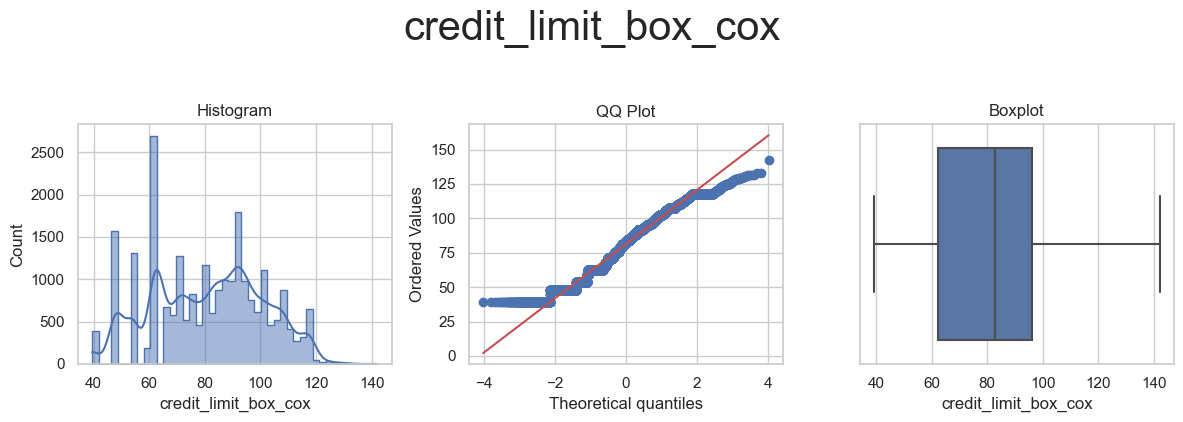

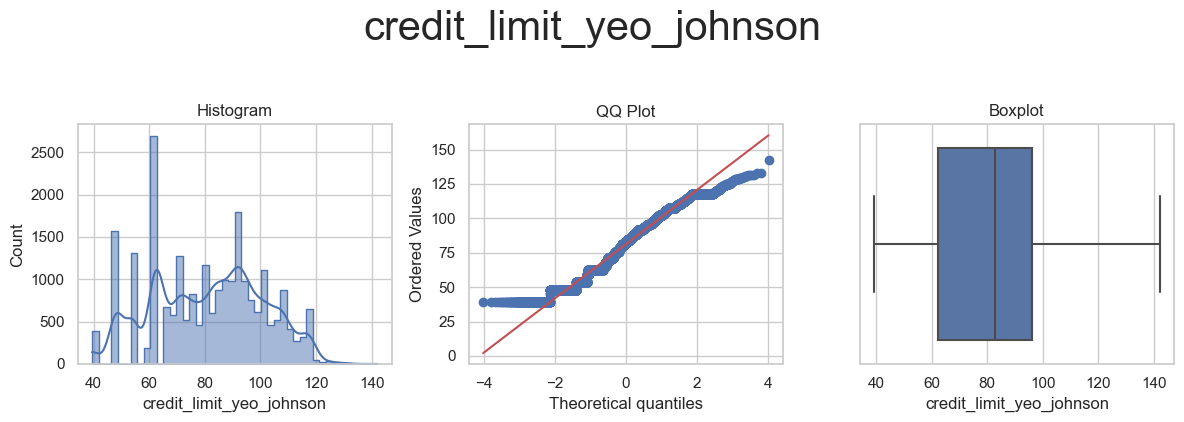



* Variable Analyzed: age
* Applied transformation: ['age_log_e', 'age_log_10', 'age_reciprocal', 'age_power', 'age_box_cox', 'age_yeo_johnson'] 



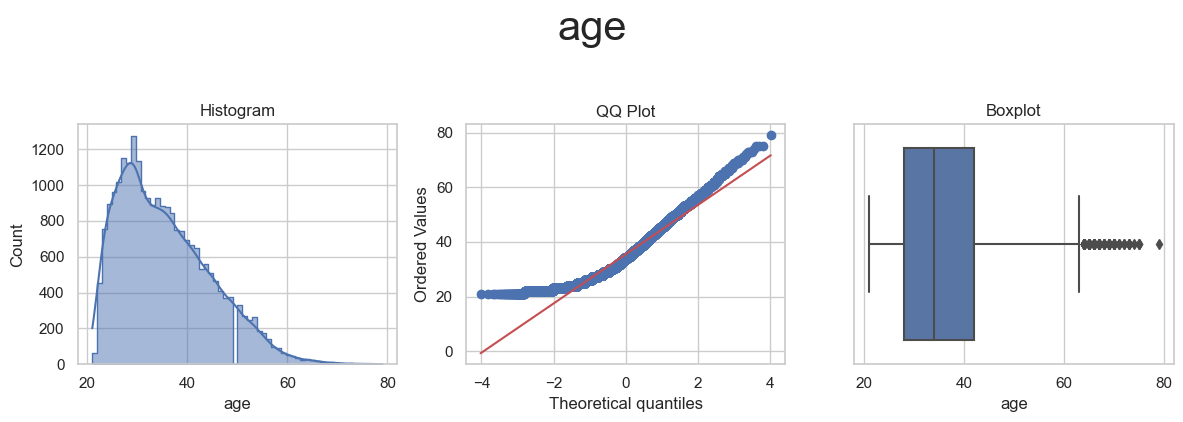

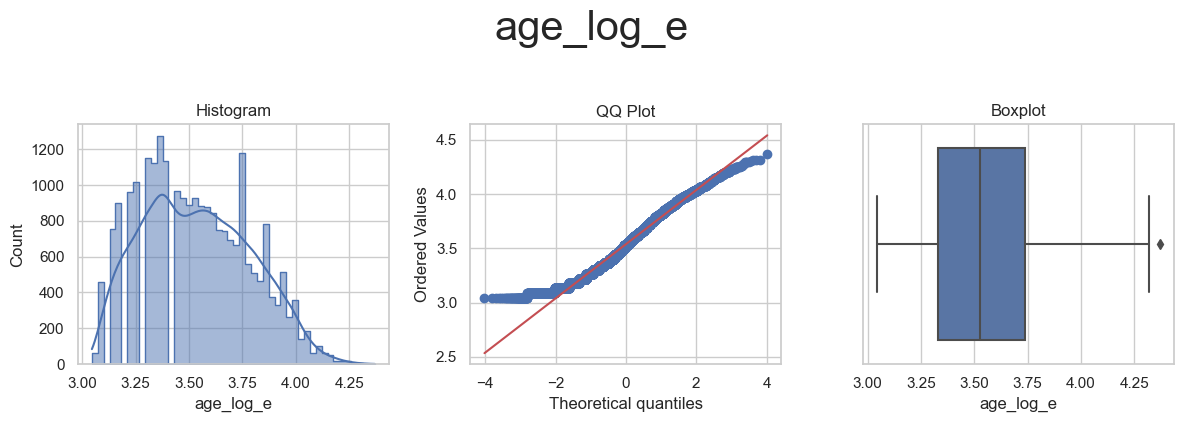

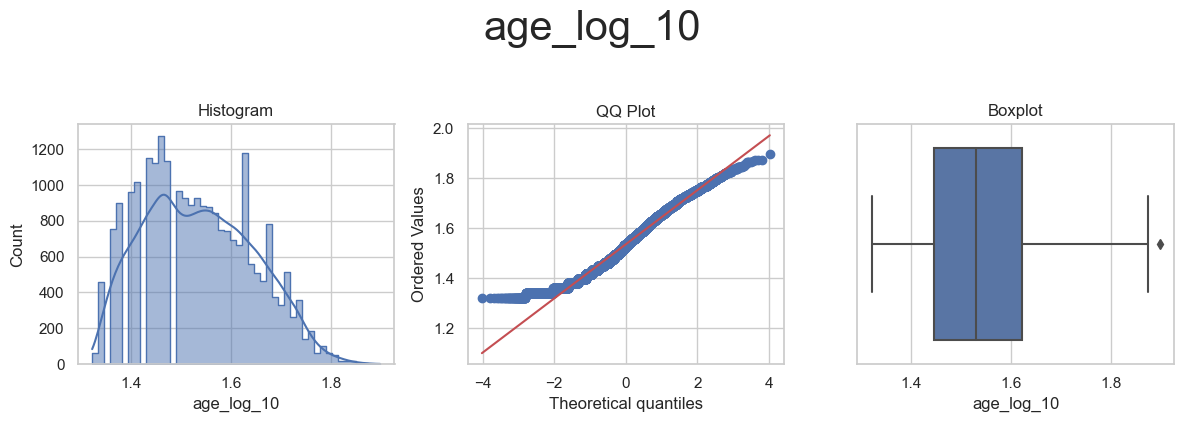

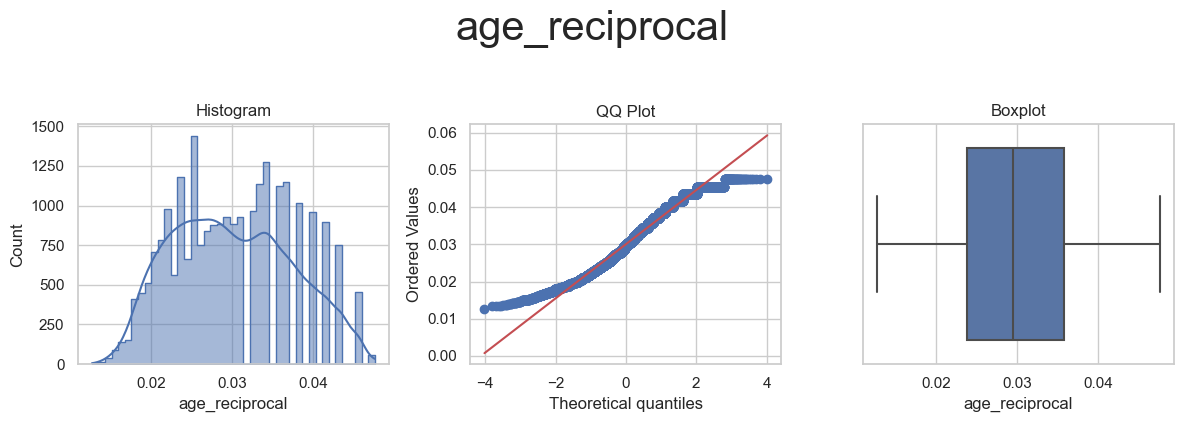

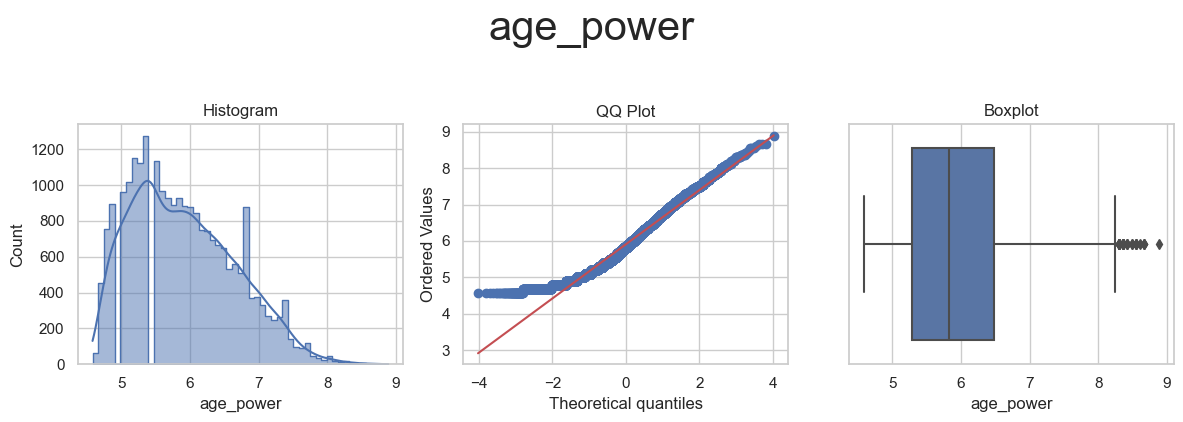

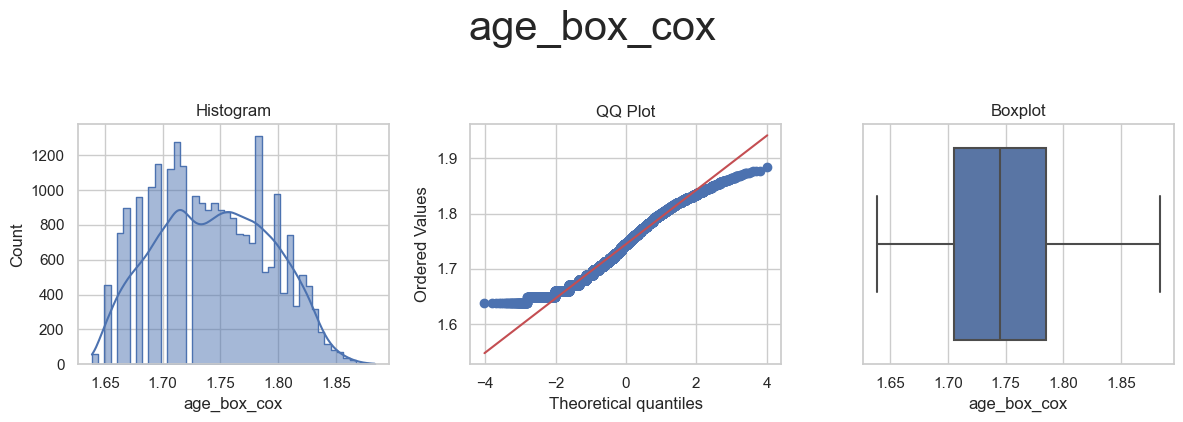

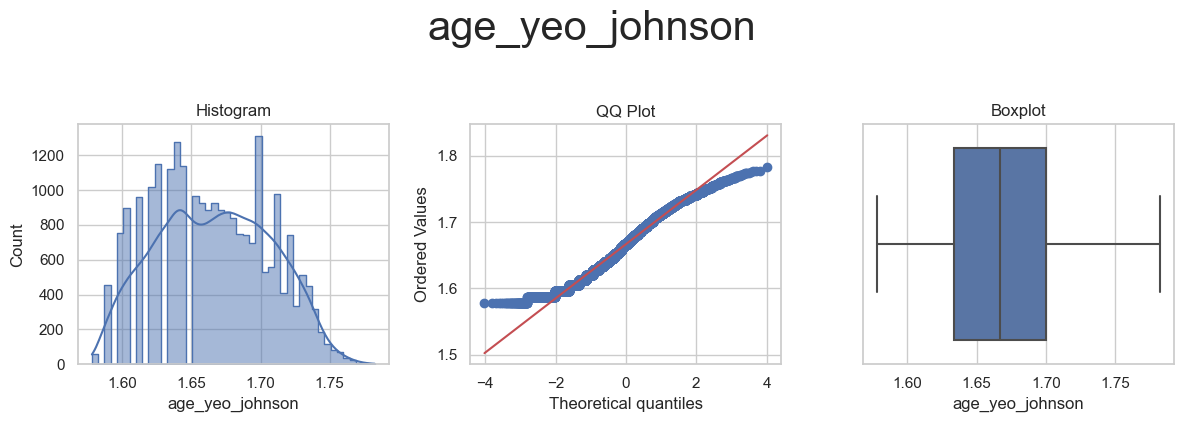



* Variable Analyzed: bill_sep
* Applied transformation: ['bill_sep_power', 'bill_sep_yeo_johnson'] 



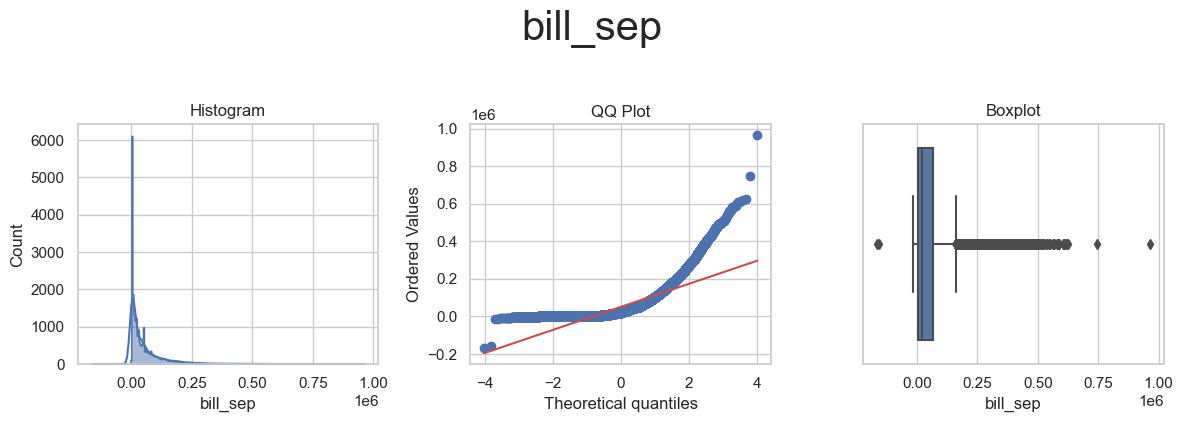

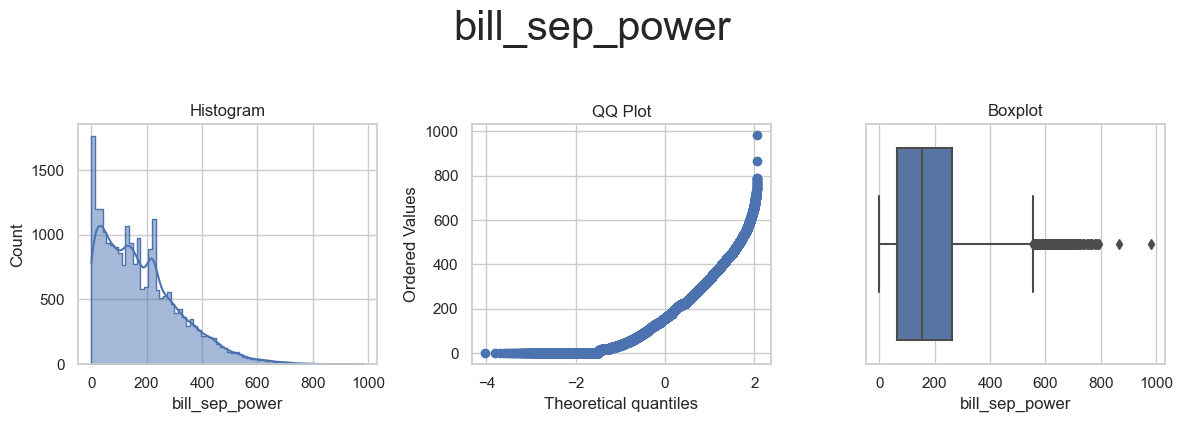

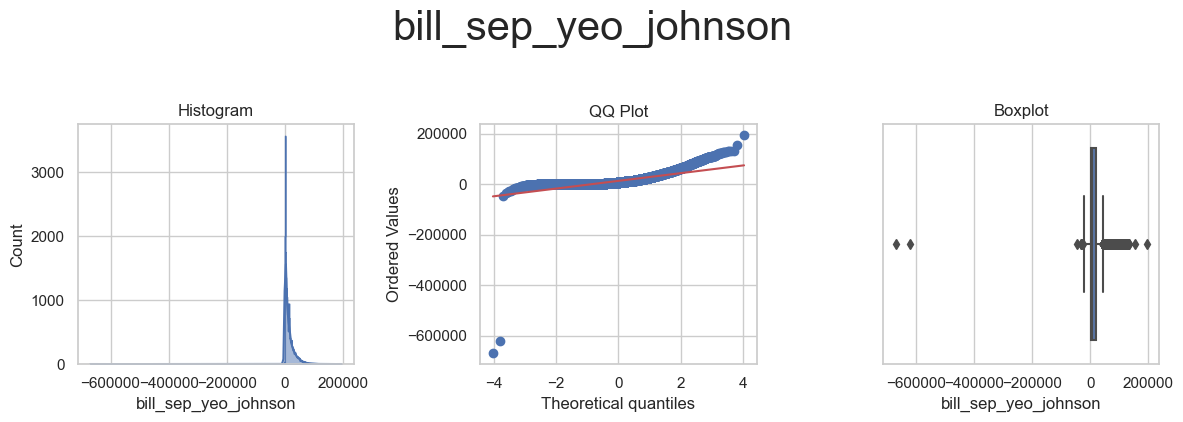



* Variable Analyzed: bill_aug
* Applied transformation: ['bill_aug_power', 'bill_aug_yeo_johnson'] 



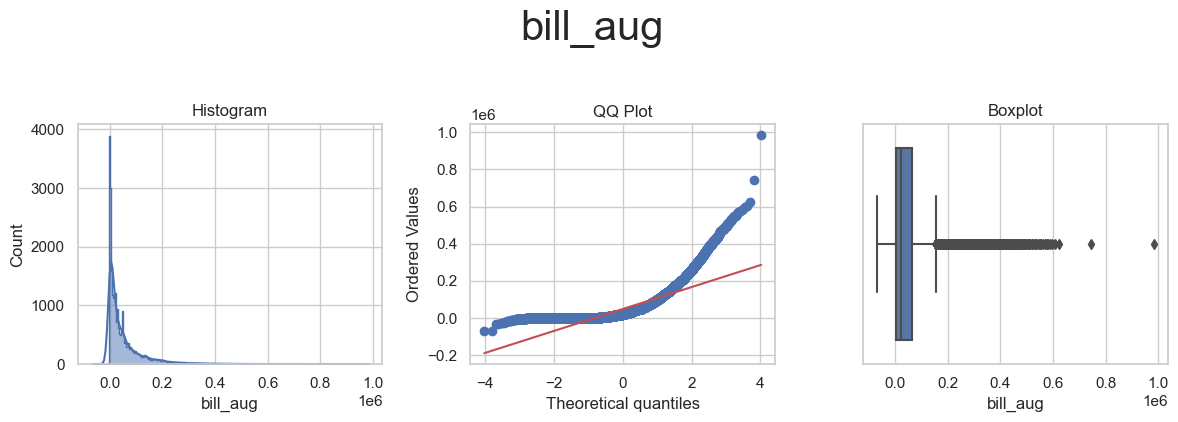

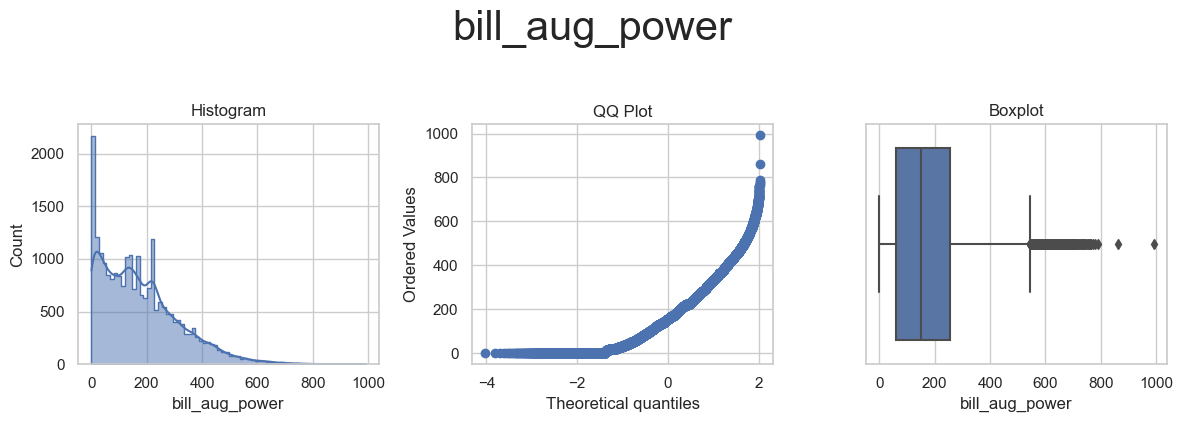

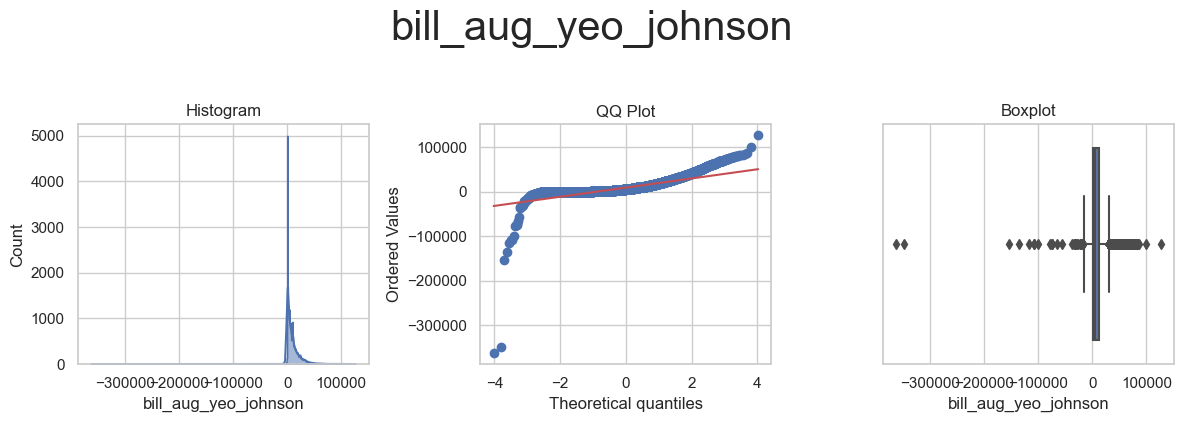



* Variable Analyzed: bill_jul
* Applied transformation: ['bill_jul_power', 'bill_jul_yeo_johnson'] 



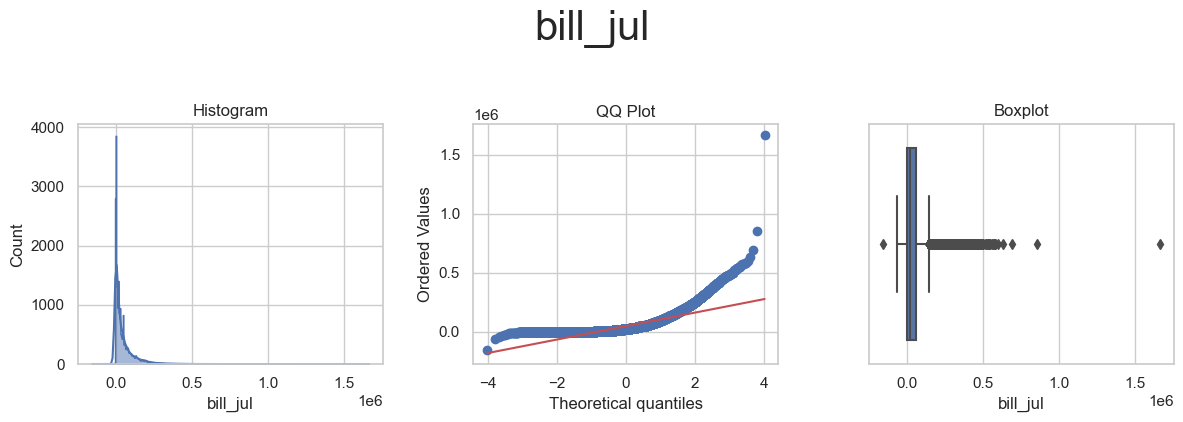

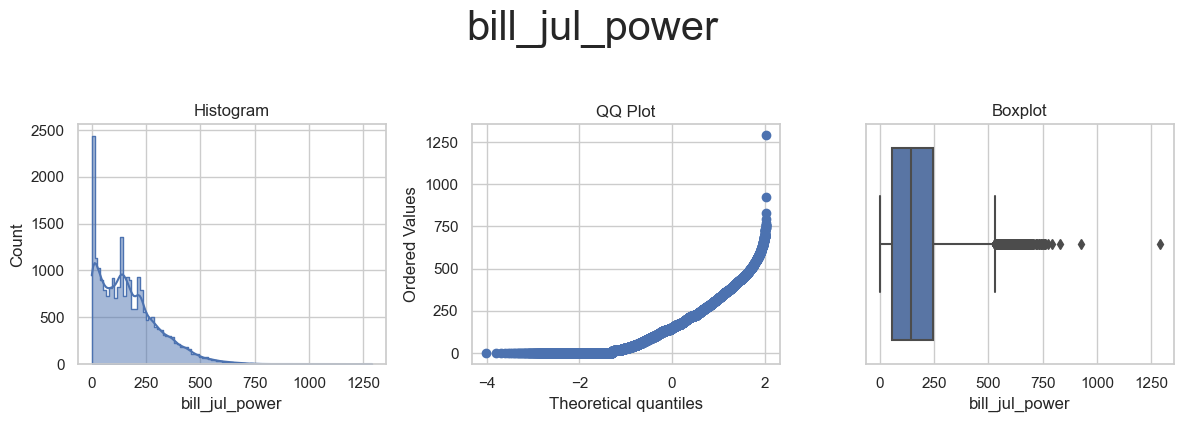

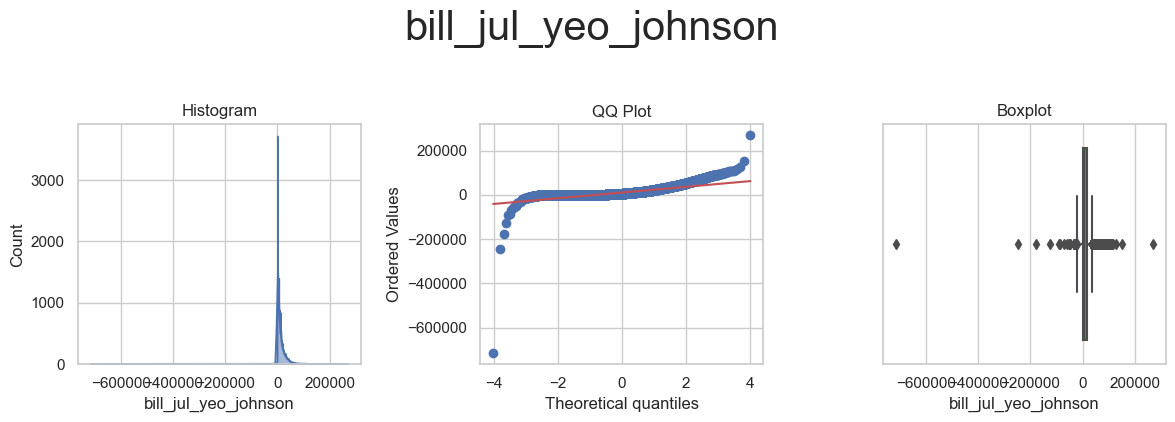



* Variable Analyzed: bill_jun
* Applied transformation: ['bill_jun_power', 'bill_jun_yeo_johnson'] 



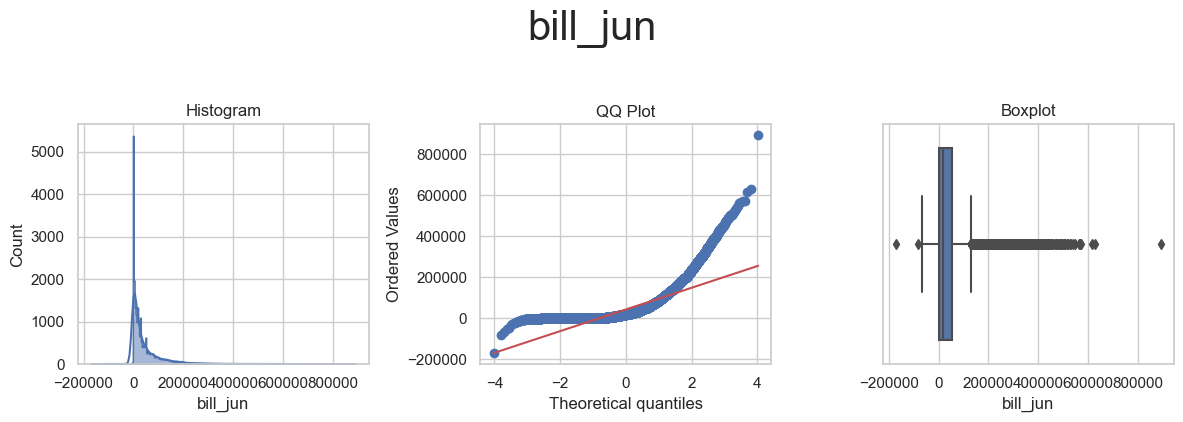

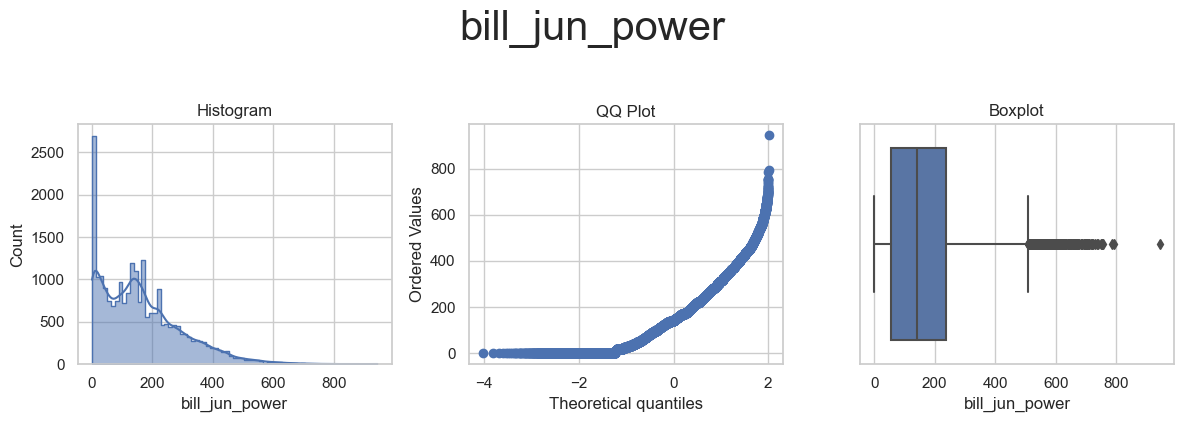

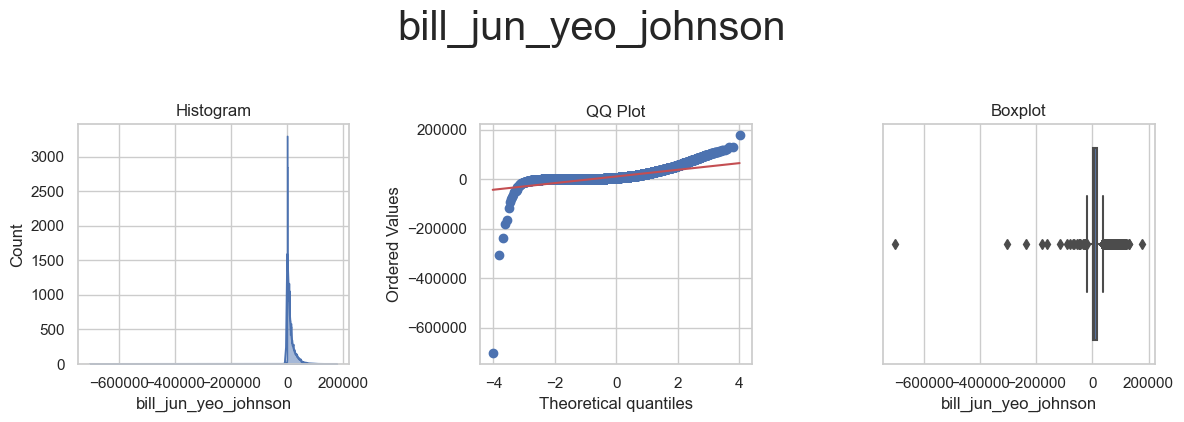



* Variable Analyzed: bill_may
* Applied transformation: ['bill_may_power', 'bill_may_yeo_johnson'] 



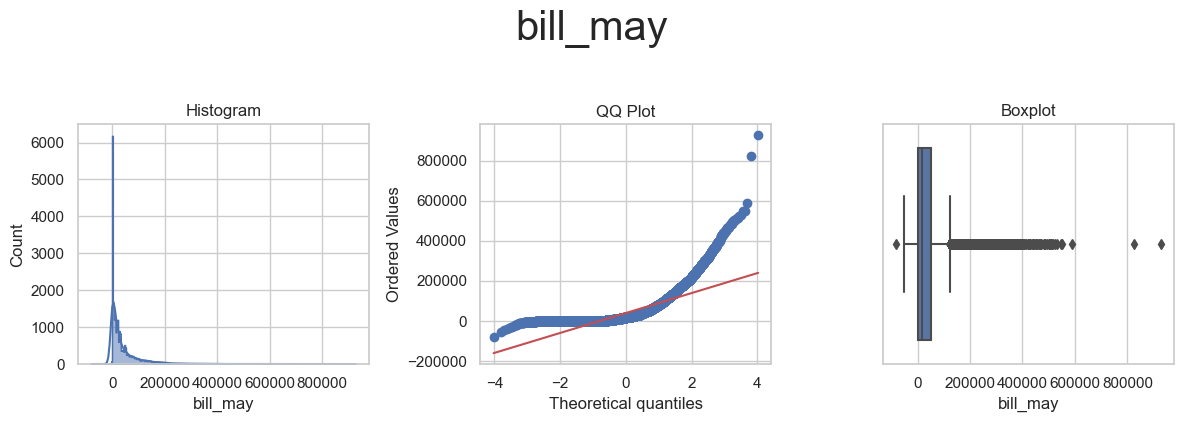

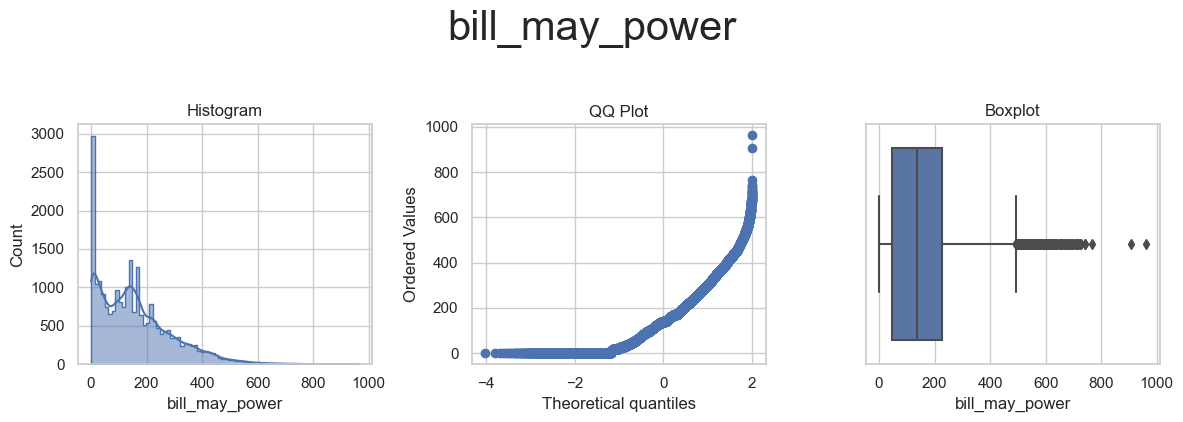

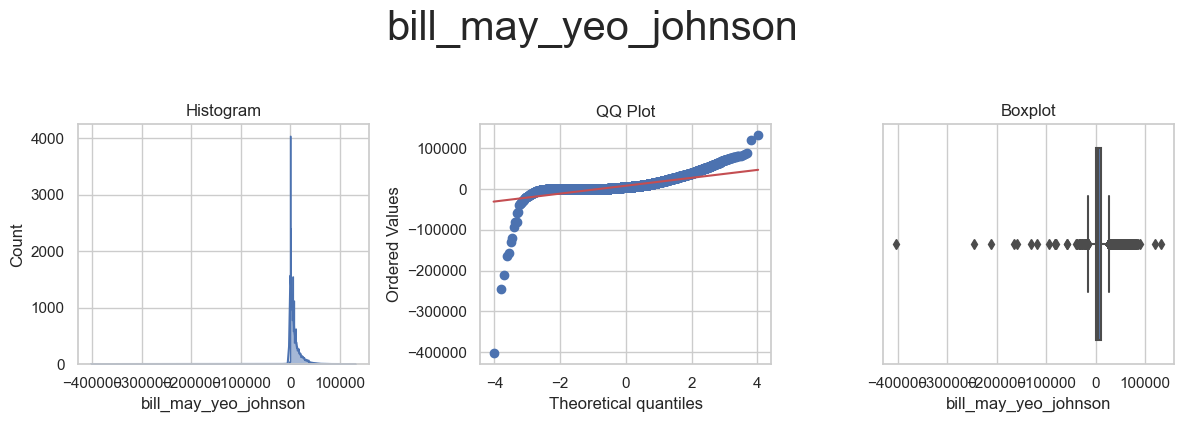



* Variable Analyzed: bill_apr
* Applied transformation: ['bill_apr_power', 'bill_apr_yeo_johnson'] 



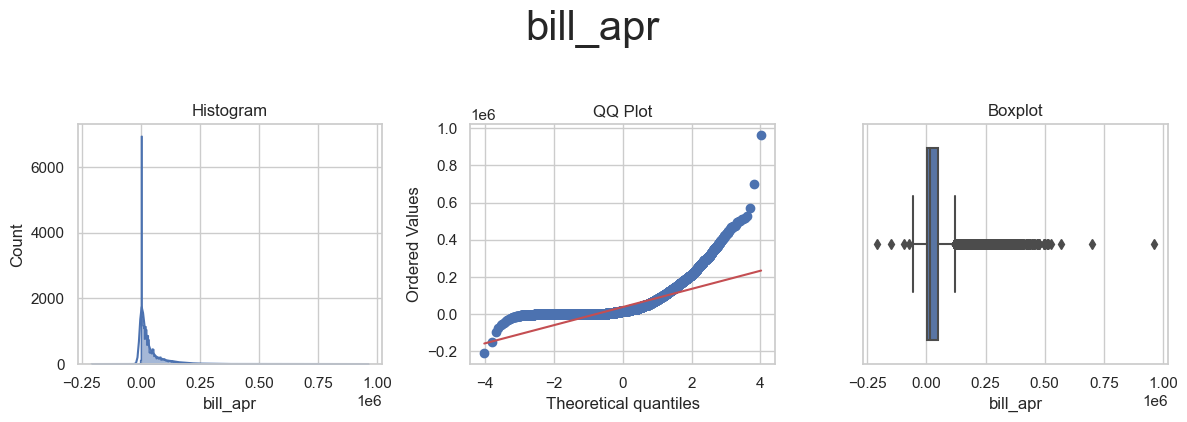

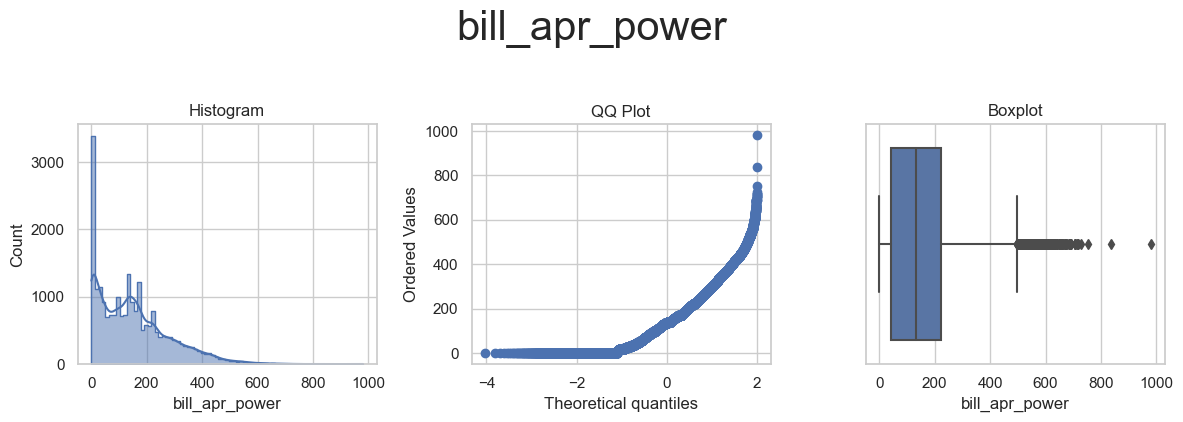

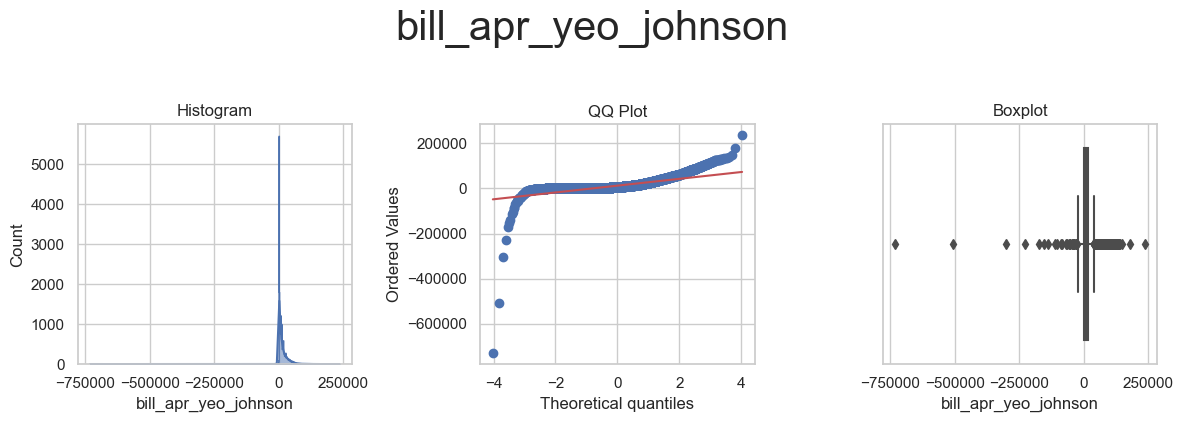



* Variable Analyzed: prev_payment_sep
* Applied transformation: ['prev_payment_sep_power', 'prev_payment_sep_yeo_johnson'] 



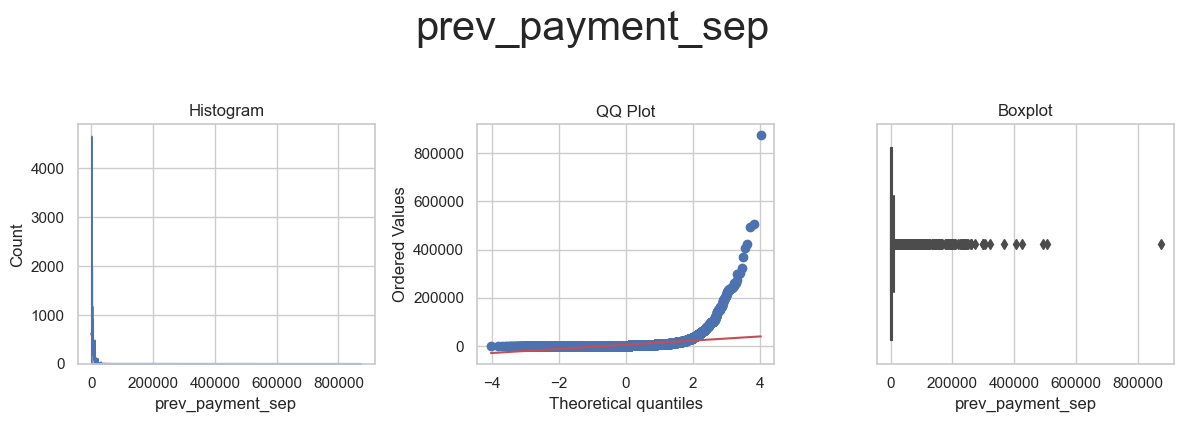

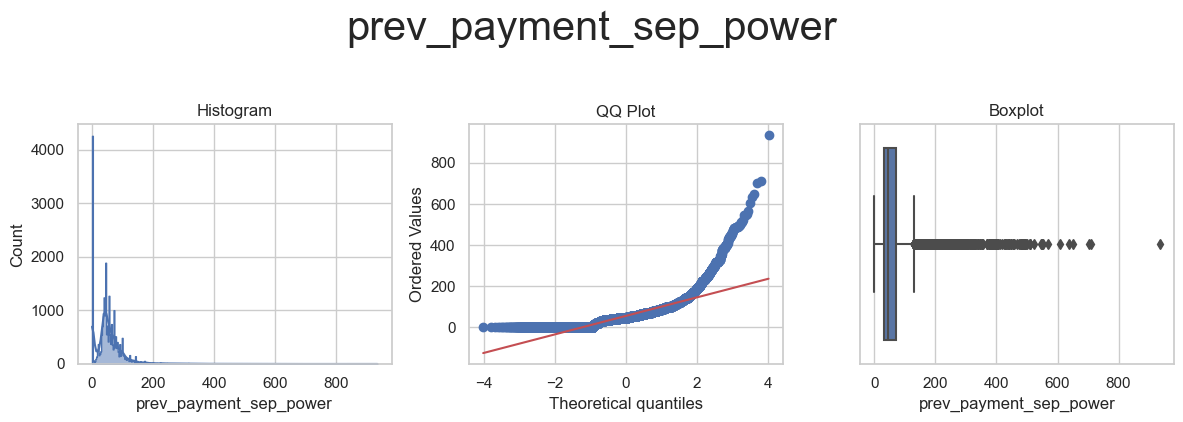

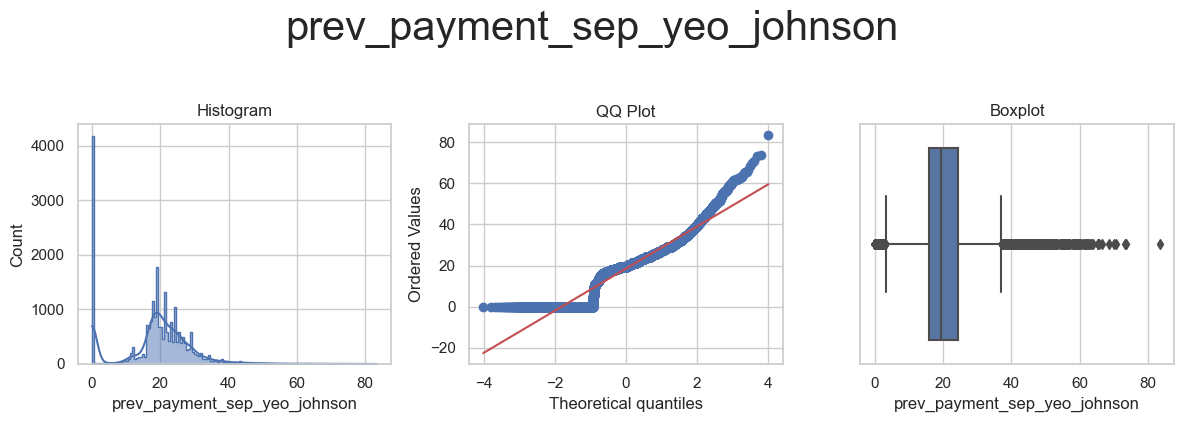



* Variable Analyzed: prev_payment_aug
* Applied transformation: ['prev_payment_aug_power', 'prev_payment_aug_yeo_johnson'] 



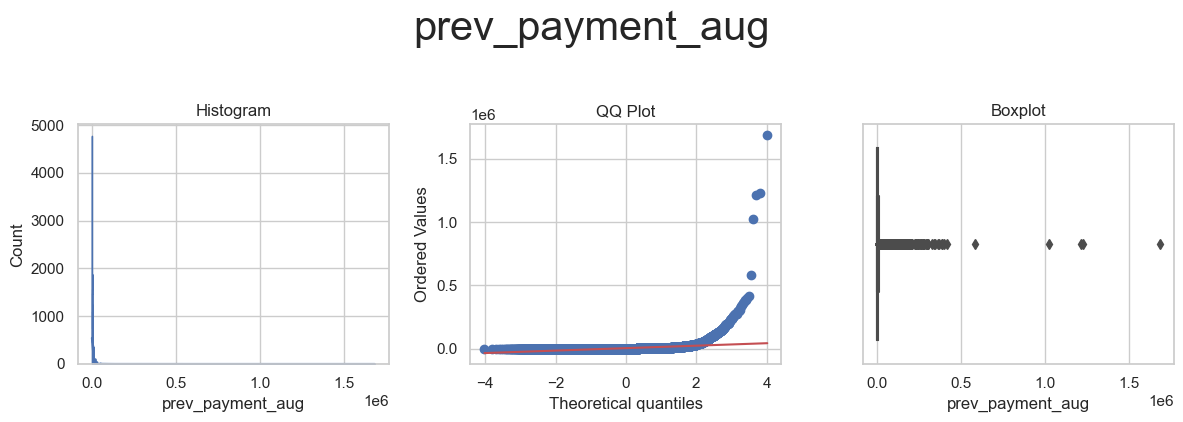

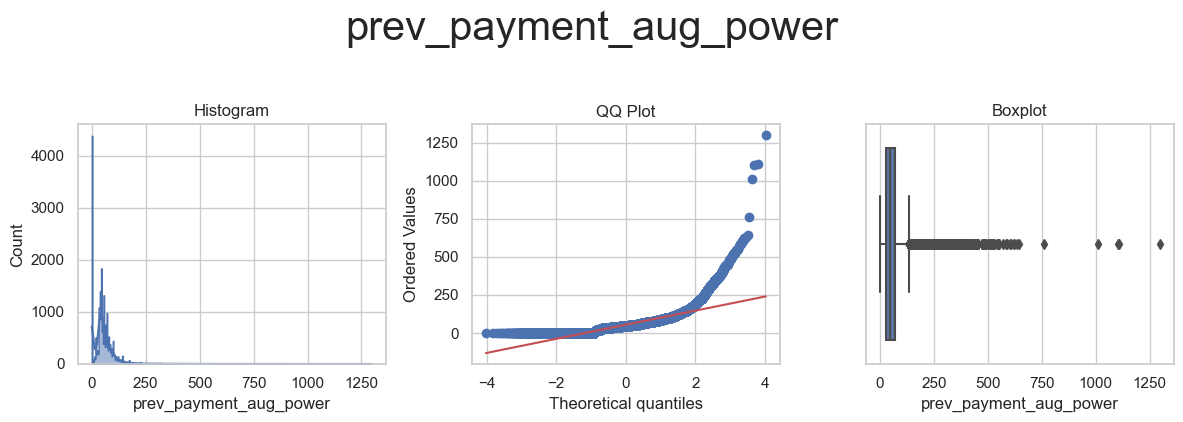

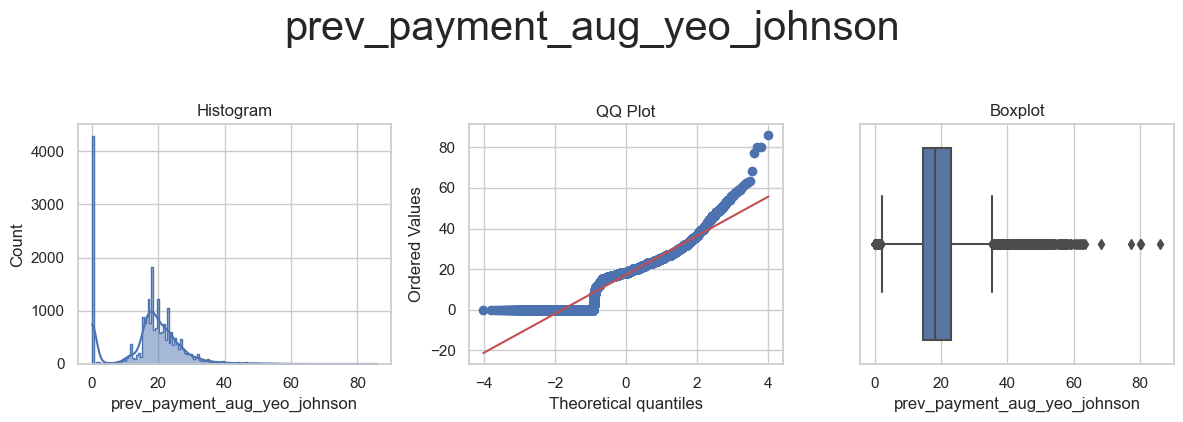



* Variable Analyzed: prev_payment_jul
* Applied transformation: ['prev_payment_jul_power', 'prev_payment_jul_yeo_johnson'] 



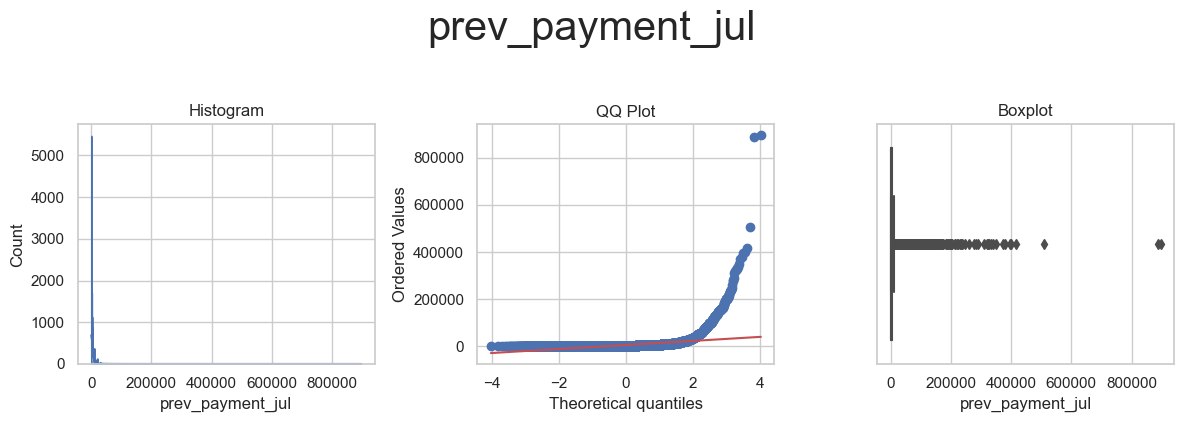

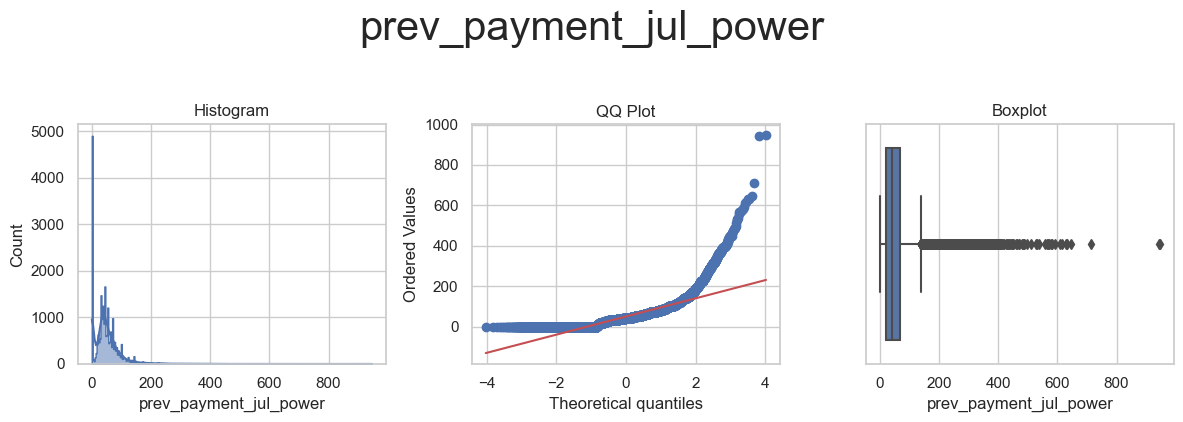

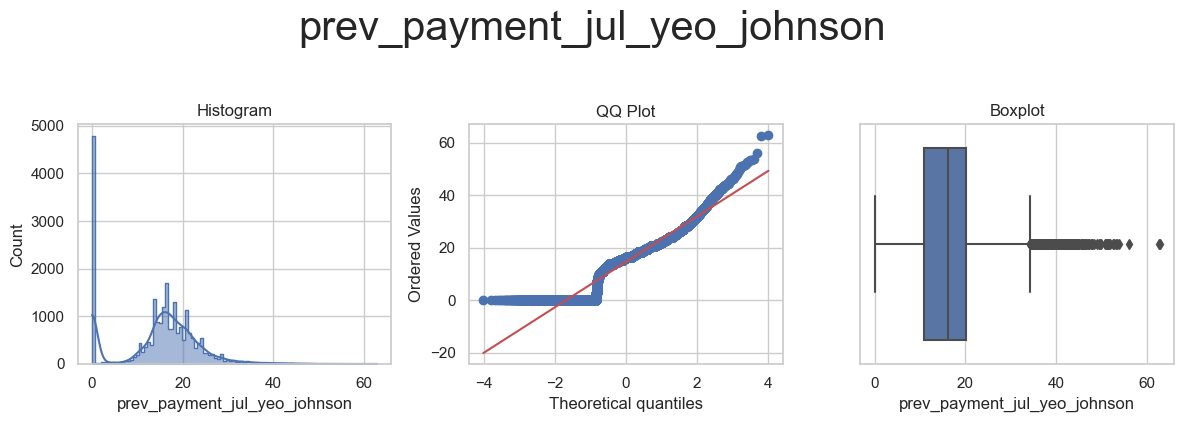



* Variable Analyzed: prev_payment_jun
* Applied transformation: ['prev_payment_jun_power', 'prev_payment_jun_yeo_johnson'] 



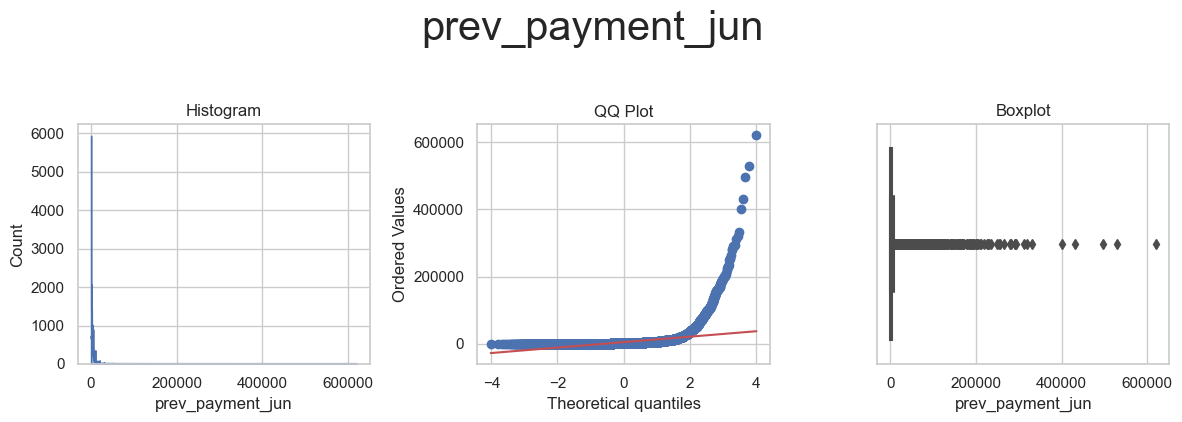

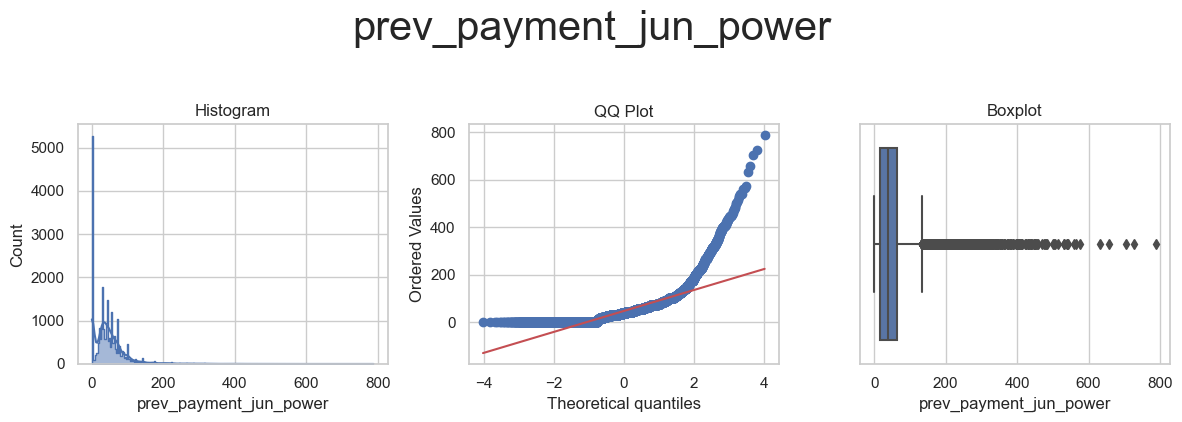

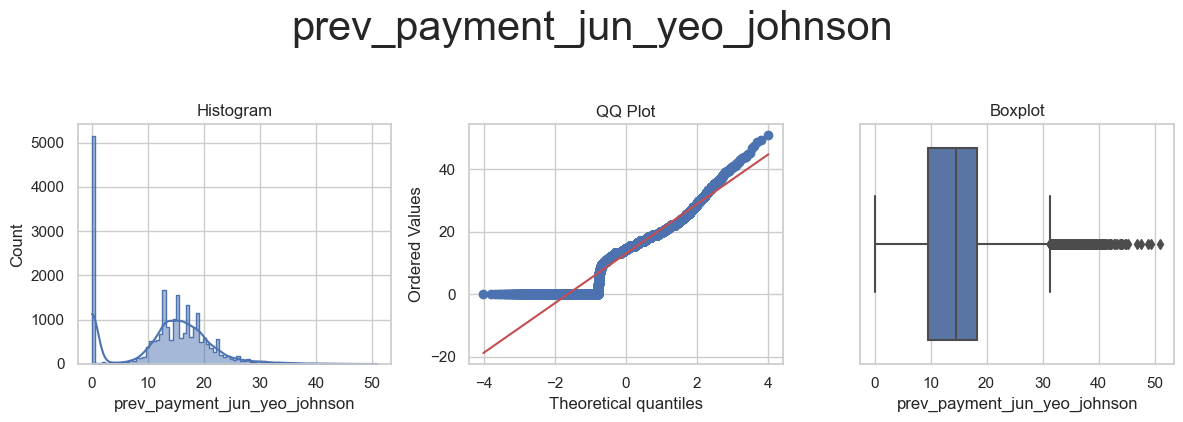



* Variable Analyzed: prev_payment_may
* Applied transformation: ['prev_payment_may_power', 'prev_payment_may_yeo_johnson'] 



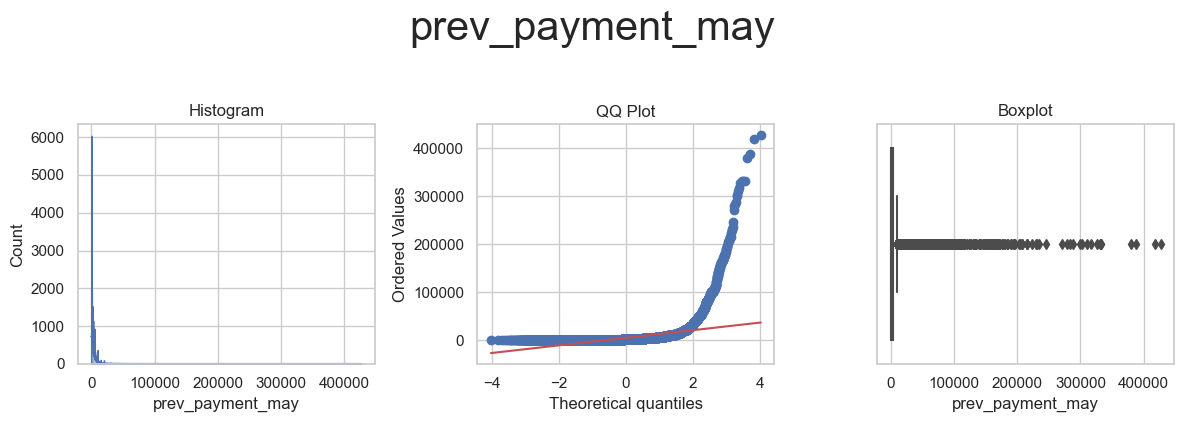

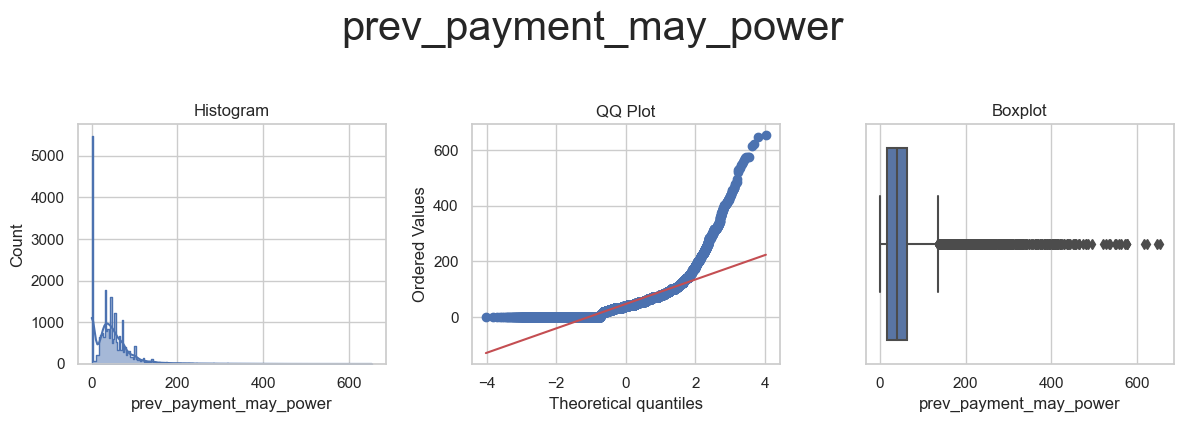

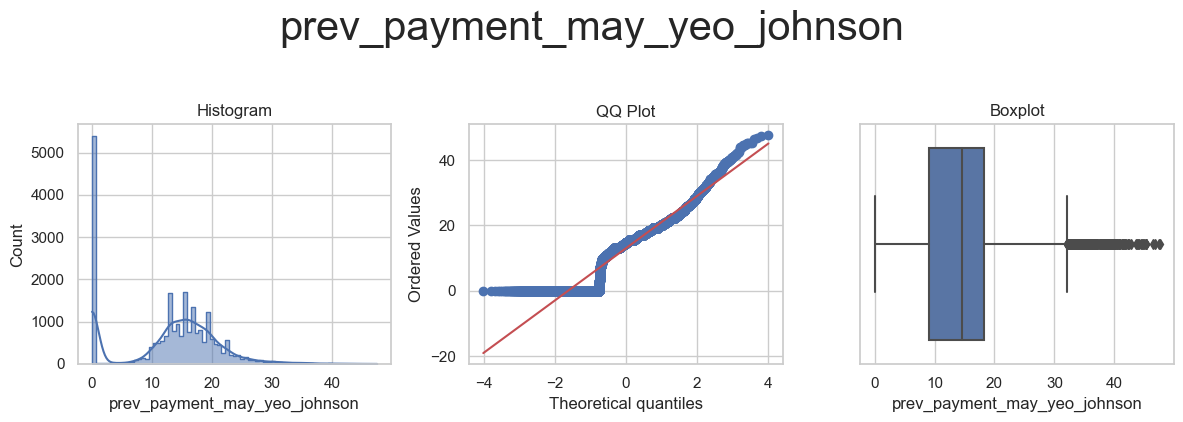



* Variable Analyzed: prev_payment_apr
* Applied transformation: ['prev_payment_apr_power', 'prev_payment_apr_yeo_johnson'] 



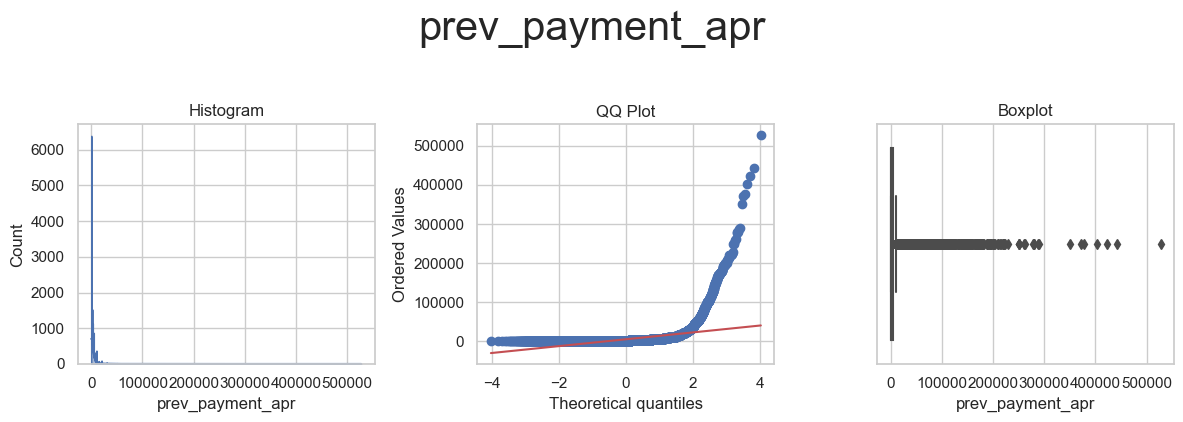

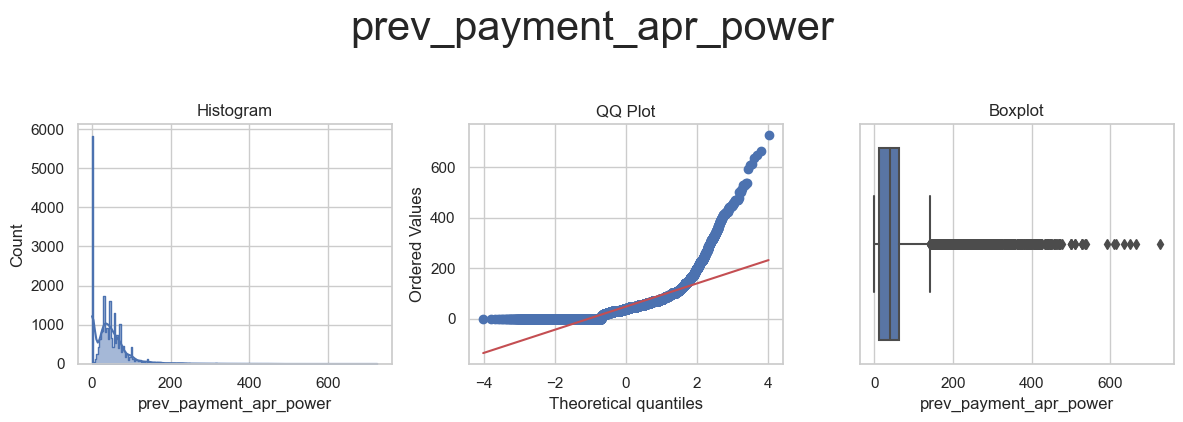

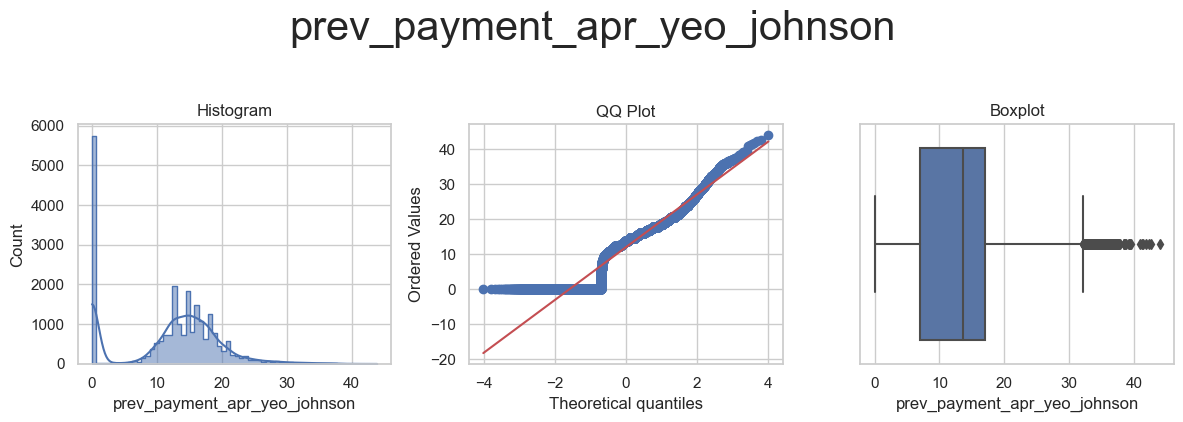

In [15]:
df_engineering = feature_engineering_analysis(df=df_engineering, analysis_type='numerical')

We can observe from the histograms and QQ plots above that none of the transformations are successful in creating a normal distribution. This can also be verified by conducting Shapiro-Wilk tests on the transformed variables. This is done here with the Box-Cox transformer, as an example:

In [17]:
from sklearn.pipeline import Pipeline

vars_to_transform = ['age', 'credit_limit']

pipeline_box_cox = Pipeline([
    ('Box-Cox-Transformer', vt.BoxCoxTransformer(variables=vars_to_transform))
])

df_box_cox = pipeline_box_cox.fit_transform(df)
df_box_cox.head()

,credit_limit,education,age,late_sep,late_aug,late_jul,late_jun,late_may,late_apr,bill_sep,...,prev_payment_may,prev_payment_apr,default_next_month,any_default,total_default,greatest_default,sex_female,marital_status_single,marital_status_married,marital_status_other
0,71.025055,2,1.670697,0,0,0,0,0,0,75125.0,...,1445.0,878.0,0,0,0,0,1,1,0,0
1,53.939397,2,1.705229,0,0,0,0,0,0,29242.0,...,0.0,0.0,0,0,0,0,0,1,0,0
2,88.910047,0,1.793453,0,0,-1,-1,-1,-1,20916.0,...,10340.0,182.0,0,0,0,0,1,0,1,0
3,65.546975,3,1.680081,0,0,0,0,0,0,58839.0,...,1900.0,2000.0,0,0,0,0,0,1,0,0
4,81.269495,2,1.680081,0,0,0,0,0,0,111587.0,...,5000.0,10700.0,0,0,0,0,1,1,0,0


In [18]:
for var in ['age', 'credit_limit']:
    data = df_box_cox[var]
    stat, p = stats.shapiro(data)
    alpha = 0.05
    
    print(f"Variable: {var}")
    print(f"Shapiro-Wilk test statistic: {stat}")
    print(f"p-value: {p}")

    if p > alpha:
        print("Data is normally distributed.\n")
    else:
        print("Data is not normally distributed.\n")

Variable: age
Shapiro-Wilk test statistic: 0.982907772064209
p-value: 1.401298464324817e-45
Data is not normally distributed.

Variable: credit_limit
Shapiro-Wilk test statistic: 0.9775547981262207
p-value: 0.0
Data is not normally distributed.



As such, for now we will not adjust the numerical variables. Depending on how the model performs, we could consider discretising these variables at a later stage.

---

# Smart Correlated Selection

For Smart Correlated selection, all variables need to be considered.

In [19]:
df_engineering = df.copy()
df_engineering.head()

,credit_limit,education,age,late_sep,late_aug,late_jul,late_jun,late_may,late_apr,bill_sep,...,prev_payment_may,prev_payment_apr,default_next_month,any_default,total_default,greatest_default,sex_female,marital_status_single,marital_status_married,marital_status_other
0,80000.0,2,24,0,0,0,0,0,0,75125.0,...,1445.0,878.0,0,0,0,0,1,1,0,0
1,30000.0,2,28,0,0,0,0,0,0,29242.0,...,0.0,0.0,0,0,0,0,0,1,0,0
2,180000.0,0,44,0,0,-1,-1,-1,-1,20916.0,...,10340.0,182.0,0,0,0,0,1,0,1,0
3,60000.0,3,25,0,0,0,0,0,0,58839.0,...,1900.0,2000.0,0,0,0,0,0,1,0,0
4,130000.0,2,25,0,0,0,0,0,0,111587.0,...,5000.0,10700.0,0,0,0,0,1,1,0,0


In [20]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

[{'any_default', 'greatest_default', 'late_aug', 'late_sep', 'total_default'},
 {'late_apr', 'late_jul', 'late_jun', 'late_may'},
 {'bill_apr', 'bill_aug', 'bill_jul', 'bill_jun', 'bill_may', 'bill_sep'},
 {'marital_status_married', 'marital_status_single'}]

Unsurprisingly, the new variables created for our initial data analysis `any_default`, `greatest_default` and `total_default` are all identified by the selector and appear in a single group. Several other groups are also identified.  
  
We now identify the least useful features from each group of correlated features; these can be dropped from the dataset:

In [21]:
corr_sel.features_to_drop_

['late_sep',
 'late_aug',
 'late_jun',
 'late_may',
 'late_apr',
 'bill_aug',
 'bill_jul',
 'bill_jun',
 'bill_may',
 'bill_apr',
 'any_default',
 'greatest_default',
 'marital_status_married']

---

# Feature Engineering Pipeline

To summarise the sections above, the steps to be undertaken within the feature engineering pipeline are:

Categorical encoding:
* Use `OneHotEncoder` for variables where no ordinal relationship exists: `sex` and `marital_status`
* Ordinally encode `education` since there is a presumed ordinal relationship between levels of education

Numerical encoding:
* None

Drop features using `DropFeatures` according to the results of `SmartCorrelatedSelection`.
* Note that `DropFeatures` is used rather than using `SmartCorrelatedSelection` again within the pipeline in order to avoid any risk that the selection of features to drop could vary when the pipeline is applied to new data and lead to different features being dropped.
* Features to drop are:
    - late_sep
    - late_aug
    - late_jun
    - late_may
    - late_apr
    - bill_aug
    - bill_jul
    - bill_jun
    - bill_may
    - bill_apr
    - any_default
    - greatest_default
    - marital_status_married



In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from feature_engine.encoding import OneHotEncoder
from feature_engine.selection import DropFeatures


def ordinal_encode_education(X):
    X['education'] = X['education'].map(education_map)
    X['education'] = X['education'].fillna(0)
    return X

variables_ohe = ['sex', 'marital_status']

education_map = {
    '0': 0,
    'other': 0,
    'unknown': 0,
    'high school': 1,
    'university': 2,
    'graduate school': 3
}

feature_engineering_pipeline = Pipeline([
      ('one_hot_encode', OneHotEncoder(variables=variables_ohe, drop_last=True)),
      ('ordinal_encode', FunctionTransformer(ordinal_encode_education)),
      ('drop',  DropFeatures(features_to_drop=['late_sep', 'late_aug', 'late_jun',
                                               'late_may', 'late_apr', 'bill_aug', 
                                               'bill_jul', 'bill_jun', 'bill_may', 
                                               'bill_apr', 'any_default', 'greatest_default',
                                               'marital_status_married'])),
])



We then test the pipeline.
* First, recreate a dataframe using the cleaned train data from the `csv` file, before any feature engineering transformations were applied:

In [23]:
df = pd.read_csv("outputs/datasets/cleaned/v1/train_set_cleaned.csv")
df.head()

,credit_limit,sex,education,marital_status,age,late_sep,late_aug,late_jul,late_jun,late_may,...,prev_payment_sep,prev_payment_aug,prev_payment_jul,prev_payment_jun,prev_payment_may,prev_payment_apr,default_next_month,any_default,total_default,greatest_default
0,80000.0,female,university,single,24,0,0,0,0,0,...,3503.0,5001.0,2092.0,1218.0,1445.0,878.0,0,0,0,0
1,30000.0,male,university,single,28,0,0,0,0,0,...,5006.0,1244.0,851.0,955.0,0.0,0.0,0,0,0,0
2,180000.0,female,unknown,married,44,0,0,-1,-1,-1,...,0.0,850.0,0.0,6881.0,10340.0,182.0,0,0,0,0
3,60000.0,male,graduate school,single,25,0,0,0,0,0,...,2018.0,1900.0,2000.0,1500.0,1900.0,2000.0,0,0,0,0
4,130000.0,female,university,single,25,0,0,0,0,0,...,4100.0,4200.0,5000.0,5000.0,5000.0,10700.0,0,0,0,0


We can see the cleaned but not transformed data above.

Next, apply the feature engineering pipeline to the dataframe:

In [24]:
df = feature_engineering_pipeline.fit_transform(df)

Finally, we check the dataframe to ensure that the pipeline has been applied successfully:

In [25]:
df.head()

,credit_limit,education,age,late_jul,bill_sep,prev_payment_sep,prev_payment_aug,prev_payment_jul,prev_payment_jun,prev_payment_may,prev_payment_apr,default_next_month,total_default,sex_female,marital_status_single,marital_status_other
0,80000.0,2,24,0,75125.0,3503.0,5001.0,2092.0,1218.0,1445.0,878.0,0,0,1,1,0
1,30000.0,2,28,0,29242.0,5006.0,1244.0,851.0,955.0,0.0,0.0,0,0,0,1,0
2,180000.0,0,44,-1,20916.0,0.0,850.0,0.0,6881.0,10340.0,182.0,0,0,1,0,0
3,60000.0,3,25,0,58839.0,2018.0,1900.0,2000.0,1500.0,1900.0,2000.0,0,0,0,1,0
4,130000.0,2,25,0,111587.0,4100.0,4200.0,5000.0,5000.0,5000.0,10700.0,0,0,1,1,0


Here we see the effects of the pipeline as intended: newly created variables using `OneHotEncoder`; the ordinal encoding of `education`; and the absence of the features identified to be dropped in the `SmartCorrelatedSelection` analysis.

---

# Push files to Repo

The feature engineering pipeline is saved so that it can be used on new data after cleaning has taken place.
* The pipeline is saved in a new folder, `outputs/ml_pipeline/feat_eng/v1`

In [26]:
import joblib

filepath = f"outputs/ml_pipeline/feat_eng/v1"

try:
    os.makedirs(name=filepath)
except Exception as e:
    print(e)

joblib.dump(value=feature_engineering_pipeline, filename=f"{filepath}/feature_engineering_pipeline.pkl")

[WinError 183] Cannot create a file when that file already exists: 'outputs/ml_pipeline/feat_eng/v1'


['outputs/ml_pipeline/feat_eng/v1/feature_engineering_pipeline.pkl']